In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
%matplotlib inline
from matplotlib import font_manager
plt.style.use('default')
f_path = "C:/windows/Fonts/malgun.ttf"
ko_font = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')
#plt.title('테스트')

In [2]:
import numpy as np
import pandas as pd
import copy
import glob
from table_evaluator import load_data, TableEvaluator
import sdmetrics
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_table import CategoricalCAP
from sklearn.model_selection import train_test_split

In [3]:
#Data Load

raw = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/rawdata.csv')

synthpop = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/synthpop_generate.csv')
ctgan = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/ctgan_generate.csv')
ctabgan = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/ctabgan_generate.csv')
ctabganplus = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/ctabganplus_generate.csv')

synthpop.drop('Unnamed: 0', axis=1, inplace=True)
ctgan.drop('Unnamed: 0', axis=1, inplace=True)
ctabgan.drop('Unnamed: 0', axis=1, inplace=True)
ctabganplus.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
raw_0025,_ = train_test_split(raw, train_size = .025, random_state = 1)
raw_005,_ = train_test_split(raw, train_size = .05, random_state = 1)
raw_010,_ = train_test_split(raw, train_size = .1, random_state = 1)
raw_020,_ = train_test_split(raw, train_size = .2, random_state = 1)
raw_030,_ = train_test_split(raw, train_size = .3, random_state = 1)
raw_040,_ = train_test_split(raw, train_size = .4, random_state = 1)
raw_050,_ = train_test_split(raw, train_size = .5, random_state = 1)
raw_060,_ = train_test_split(raw, train_size = .6, random_state = 1)
raw_070,_ = train_test_split(raw, train_size = .7, random_state = 1)
raw_080,_ = train_test_split(raw, train_size = .8, random_state = 1)
raw_090,_ = train_test_split(raw, train_size = .9, random_state = 1)
raw_095,_ = train_test_split(raw, train_size = .95, random_state = 1)
raw_0975,_ = train_test_split(raw, train_size = .975, random_state = 1)
raw_100 = copy.deepcopy(raw)


In [5]:
def pMSE(real_data, fake_data):
    
    real = copy.deepcopy(real_data)
    fake = copy.deepcopy(fake_data)
    
    real['target'] = 0
    fake['target'] = 1

    merge = pd.concat([real, fake])
    # 학습데이터, taget 분리
    X = merge.drop(['target'], axis = 1)
    Y = merge['target']

    # 범주형 변수 One-hot Encoding, 수치형 변수는 Scaling
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    cate_X = merge[['저소득층여부','교육수준','혼인상태','가구형태','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스']]
    conti_X = merge[['나이','총생활비','총소득']]

    cate_X_dummy=pd.get_dummies(cate_X)

    scaler_X=StandardScaler()
    conti_X_st=scaler_X.fit_transform(conti_X)

    conti_X_st=pd.DataFrame(conti_X_st, columns=conti_X.columns)

    cate_X_dummy.reset_index(inplace=True, drop=True)
    conti_X_st.reset_index(inplace=True, drop=True)
    Y.reset_index(inplace=True, drop=True)

    # train set
    train_set=pd.concat([conti_X_st,cate_X_dummy], axis=1)
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    
    #Logistic Reggression
    model_log = LogisticRegression(penalty = 'l2', solver='saga', random_state=0) 
    model_log.fit(train_set, Y) # 모델 학습

    y_pred= model_log.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_logistic = s*(1/(n0+n1))

    #RandomForest
    model_rf = RandomForestClassifier(random_state=0) 
    model_rf.fit(train_set, Y) # 모델 학습

    y_pred= model_rf.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_rf = s*(1/(n0+n1))

    #SVM
    model_svc = SVC(kernel = 'rbf', probability=True, random_state=0)
    model_svc.fit(train_set, Y) # 모델 학습

    y_pred= model_svc.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_svm = s*(1/(n0+n1))

    #3가지 분류기 평균값 도출
    pMSE = (pMSE_logistic + pMSE_rf + pMSE_svm)/3
    
    real.drop('target', axis=1, inplace=True)
    fake.drop('target', axis=1, inplace=True)
    
    return pMSE

# Model Evaluation Without Sampling

In [6]:
df = pd.DataFrame()

df['model_size'] = ['raw_002.5', 'raw_005', 'raw_010', 'raw_020', 'raw_030', 'raw_040', 'raw_050', 
                    'raw_060', 'raw_070', 'raw_080', 'raw_090', 'raw_095', 'raw_097.5', 'raw_100',
                    
                   'SYNTHPOP', 'CTGAN', 'CTABGAN', 'CTABGANPLUS']
df['model'] = df['model_size'].str.extract('([A-Za-z+]+)')
df['sample_size'] = df['model_size'].str.extract('(\d+\.\\d+|\d+\d+)').astype('float')
df = df.sort_values(['model','sample_size'])
df['sample_size'] = df['sample_size'].astype('str') + '%'

df.loc[df['sample_size'] == 'nan%', 'sample_size'] = df.model
df

,model_size,model,sample_size
16,CTABGAN,CTABGAN,CTABGAN
17,CTABGANPLUS,CTABGANPLUS,CTABGANPLUS
15,CTGAN,CTGAN,CTGAN
14,SYNTHPOP,SYNTHPOP,SYNTHPOP
0,raw_002.5,raw,2.5%
1,raw_005,raw,5.0%
2,raw_010,raw,10.0%
3,raw_020,raw,20.0%
4,raw_030,raw,30.0%
5,raw_040,raw,40.0%


In [7]:
model_data = [ctabgan, ctabganplus, ctgan, synthpop,
              
              raw_0025, raw_005, raw_010, raw_020, raw_030, raw_040, raw_050, raw_060, 
              raw_070, raw_080, raw_090, raw_095, raw_0975, raw_100]

In [8]:
#TCAP : taget(저소득층여부, 나이, 혼인상태, 가구형태, 총생활비), key(그 외 나머지)
TCAP_value = []
pMSE_value = []
for i in range(len(model_data)):
    TCAP_score_1 = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=model_data[i],
    key_fields=['교육수준','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스','총소득'],
    sensitive_fields=['저소득층여부']
    )
    
    TCAP_score_2 = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=model_data[i],
    key_fields=['교육수준','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스','총소득'],
    sensitive_fields=['나이']
    )
    
    TCAP_score_3 = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=model_data[i],
    key_fields=['교육수준','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스','총소득'],
    sensitive_fields=['혼인상태']
    )
    
    TCAP_score_4 = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=model_data[i],
    key_fields=['교육수준','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스','총소득'],
    sensitive_fields=['가구형태']
    )
    
    
    TCAP_score_5 = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=model_data[i],
    key_fields=['교육수준','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스','총소득'],
    sensitive_fields=['총생활비']
    )
    
    TCAP_score = (TCAP_score_1+TCAP_score_2+TCAP_score_3+TCAP_score_4+TCAP_score_5)/5

    pMSE_score = pMSE(raw, model_data[i])
    
    TCAP_value.append(TCAP_score)
    pMSE_value.append(pMSE_score)
    

C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

In [9]:
df['TCAP'] = [1 - x for x in TCAP_value]
df['pMSE'] = [1 - x*(1/4) for x in pMSE_value]

# TCAP, pMSE Visualize

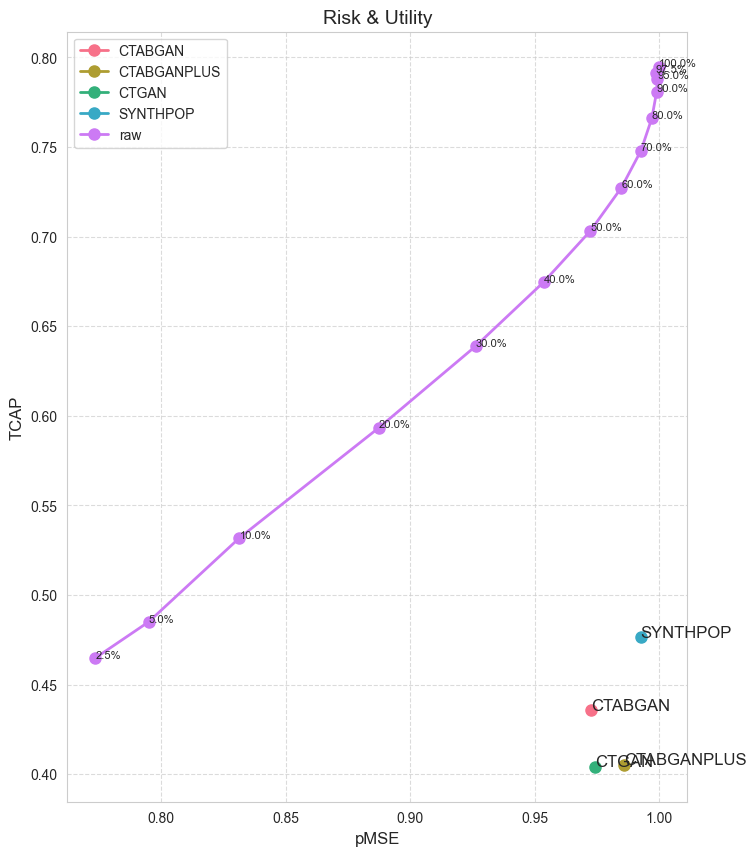

In [17]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 10))

# 색상 설정
palette = sns.color_palette("husl", n_colors=len(df['model'].unique()))

# 그래프 그리기
for i, model in enumerate(df['model'].unique()):
    model_data = df[df['model'] == model]
    ax.plot(model_data['pMSE'], model_data['TCAP'], marker='o', linestyle='-', label=model, markersize=8, linewidth=2, color=palette[i])

    # 샘플 사이즈 넣기
    for i, txt in enumerate(model_data['sample_size']):
        if txt in ['SYNTHPOP','CTGAN', 'CTABGAN', 'CTABGANPLUS']:
            ax.annotate(txt, (model_data['pMSE'].iloc[i], model_data['TCAP'].iloc[i]), fontsize=12)
        
        else:
            ax.annotate(txt, (model_data['pMSE'].iloc[i], model_data['TCAP'].iloc[i]), fontsize=8)

# 축 label, title
ax.set_xlabel('pMSE', fontsize=12)
ax.set_ylabel('TCAP', fontsize=12)
ax.set_title('Risk & Utility', fontsize=14)

# legend
ax.legend(fontsize=10)

# grid 형태
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [11]:
df

,model_size,model,sample_size,TCAP,pMSE
16,CTABGAN,CTABGAN,CTABGAN,0.435533,0.972731
17,CTABGANPLUS,CTABGANPLUS,CTABGANPLUS,0.405246,0.985769
15,CTGAN,CTGAN,CTGAN,0.404147,0.974319
14,SYNTHPOP,SYNTHPOP,SYNTHPOP,0.476375,0.992428
0,raw_002.5,raw,2.5%,0.464872,0.773588
1,raw_005,raw,5.0%,0.484972,0.794921
2,raw_010,raw,10.0%,0.531860,0.831411
3,raw_020,raw,20.0%,0.593261,0.887301
4,raw_030,raw,30.0%,0.638883,0.926247
5,raw_040,raw,40.0%,0.674572,0.953487


In [18]:
df.to_csv('evaluate.csv', encoding='UTF-8-sig')